In [2]:
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
from warnings import filterwarnings 
filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import mean_squared_error, mean_absolute_error 
from sklearn.model_selection import train_test_split

In [16]:
# Read data
rossman_df = pd.read_csv('data/rossmann-store-sales/train.csv')
rossman_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [44]:
# I'm exploring only Store 2
store_2 = rossman_df.query('Store == 2')
store_2.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
1,2,5,2015-07-31,6064,625,1,1,0,1
1116,2,4,2015-07-30,5567,601,1,1,0,1
2231,2,3,2015-07-29,6402,727,1,1,0,1
3346,2,2,2015-07-28,5671,646,1,1,0,1
4461,2,1,2015-07-27,6627,638,1,1,0,1


In [19]:
# Let's now change column Date into an appropriate time stamp index
# and drop all columns except column Sales
store_2['Date'] = pd.to_datetime(store_2['Date'])
store_2 = store_2.set_index('Date')[['Sales']]
store_2.head()

,Sales
Date,
2015-07-31,6064
2015-07-30,5567
2015-07-29,6402
2015-07-28,5671
2015-07-27,6627


In [28]:
# Indices are sorted backward so I will sort them the correct way
store_2 = store_2.sort_index()
store_2.tail(200)

,Sales
Date,
2015-01-13,6444
2015-01-14,6366
2015-01-15,5810
2015-01-16,5456
2015-01-17,2883
...,...
2015-07-27,6627
2015-07-28,5671
2015-07-29,6402


In [30]:
# The training data before the date 2015-01-14
# The testing data after the date 2015-01-13
X_train, X_test = store_2[:'2015-01-14'], store_2['2015-01-13':]
print(X_train.tail())
print(X_test.head())

            Sales
Date             
2015-01-10   3024
2015-01-11      0
2015-01-12   7237
2015-01-13   6444
2015-01-14   6366
            Sales
Date             
2015-01-13   6444
2015-01-14   6366
2015-01-15   5810
2015-01-16   5456
2015-01-17   2883


### Check that the signal is stationary

In [31]:
p_val = adfuller(X_train)[1]
print(f'p-value: {p_val: .7f}')

p-value:  0.0000133


In [8]:
# p-value less than 1 so it is not stationary and we can reject the null hypothesis 

### Autocorrelation 

Text(0.5, 1.0, 'Partial Autocorrelation')

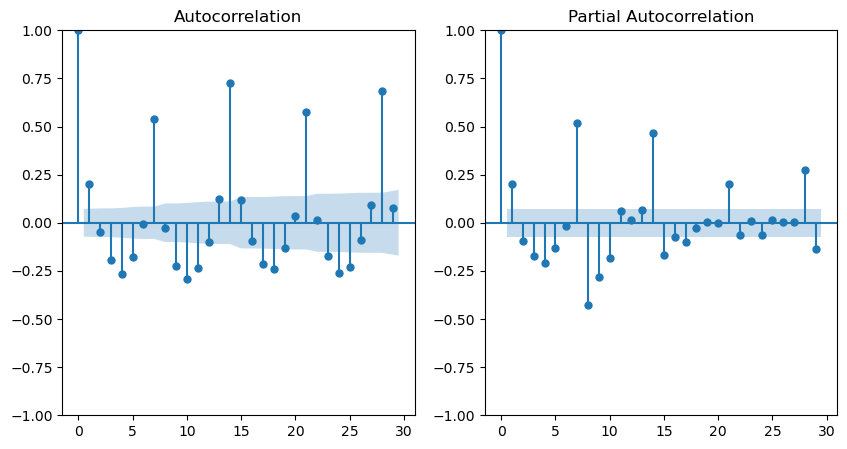

In [34]:
#  Autocorrelation and partial autocorrelation to see if X_train is stationary
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
plot_acf(X_train, ax = ax[0])
ax[0].set_title('Autocorrelation')
plot_pacf(X_train, ax = ax[1])
ax[1].set_title('Partial Autocorrelation')

In [35]:
# It looks like stationary.

### Use SACF and SPACF to select p and q

In [11]:
# According to acf and pacf, it would seem that p = 3 and q = 1 may be our best bet
p = 3
q = 1

### Compute the θ and Φ coefficients of MA(q) and AR(p) parts

### ARIMA Model

In [36]:
# Using the ARIMA Model for order = (p, 0, q)
arma = ARIMA(X_train, order=(p,0,q)).fit()
arma_preds = arma.forecast(len(X_test))
arma_mae_test = mean_absolute_error(X_test, arma_preds)
arma_rmse_test = mean_squared_error(X_test, arma_preds, squared=False)

print(f'ARIMA MAE: {arma_mae_test}')
print(f'ARIMA RMSE: {arma_rmse_test}')

ARIMA MAE: 1827.0192838835426
ARIMA RMSE: 2331.1207448096757


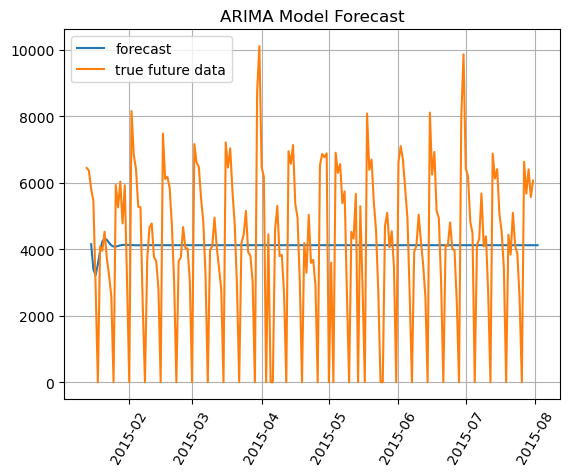

In [37]:
plt.plot(arma_preds, label = 'forecast')
plt.plot(X_test, label = 'true future data')
plt.title('ARIMA Model Forecast')
plt.legend()
plt.xticks(rotation = 60)
plt.grid()

In [38]:
# There appears to be a certain level of seasonality in the true future data.
# Let's utilize the SARIMAX model to determine if it can provide more accurate forecasts.

### Compute the residuals

### SARIMAX Model

In [39]:
sarima = SARIMAX(X_train, order=(p,0,q), seasonal_order=(p,2,q,12)).fit()
sarima.summary()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.44511D+00    |proj g|=  2.87008D-01

At iterate    5    f=  9.36221D+00    |proj g|=  7.24565D-02

At iterate   10    f=  9.33099D+00    |proj g|=  1.62857D-02

At iterate   15    f=  9.32856D+00    |proj g|=  7.45331D-04

At iterate   20    f=  9.32852D+00    |proj g|=  1.20342D-03

At iterate   25    f=  9.32351D+00    |proj g|=  2.13549D-02

At iterate   30    f=  9.31850D+00    |proj g|=  4.54999D-03

At iterate   35    f=  9.31831D+00    |proj g|=  1.36927D-04

At iterate   40    f=  9.31829D+00    |proj g|=  1.61262D-03

At iterate   45    f=  9.31689D+00    |proj g|=  1.14091D-02

At iterate   50    f=  9.26870D+00    |proj g|=  1.54954D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Sales   No. Observations:                  744
Model:             SARIMAX(3, 0, 1)x(3, 2, 1, 12)   Log Likelihood               -6895.911
Date:                            Mon, 21 Aug 2023   AIC                          13809.822
Time:                                    10:20:45   BIC                          13851.035
Sample:                                01-01-2013   HQIC                         13825.732
                                     - 01-14-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3314      1.111     -0.298      0.765      -2.509       1.846
ar.L2         -0.3807      0.416     -0.914      0.361      -1.197       0.436
ar.L3         -0.4398      0.784     -0.561      0.575      -1.976       1.096
ma.L1          0.7202      1.112      0.648      0.517      -1.458       2.899
ar.S.L12      -0.4309      0.078     -5.511      0.000      -0.584      -0.278
ar.S.L24      -0.4284      0.080     -5.322      0.000      -0.586      -0.271
ar.S.L36      -0.1736      0.072     -2.397      0.017      -0.316      -0.032
ma.S.L12      -0.9984      0.101     -9.874      0.000      -1.197      -0.800
sigma2      1.748e+07   3.08e-08   5.68e+14      0.000    1.75e+07    1.75e+07
===================================================================================
Ljung-Box (L1) (Q):                  45.40   Jarque-Bera (JB):                 7.16
Prob(Q):                              0.00   Prob(JB):                         0.03
Heteroskedasticity (H):               1.16   Skew:                             0.10
Prob(H) (two-sided):                  0.25   Kurtosis:                         2.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.23e+32. Standard errors may be unstable.
"""

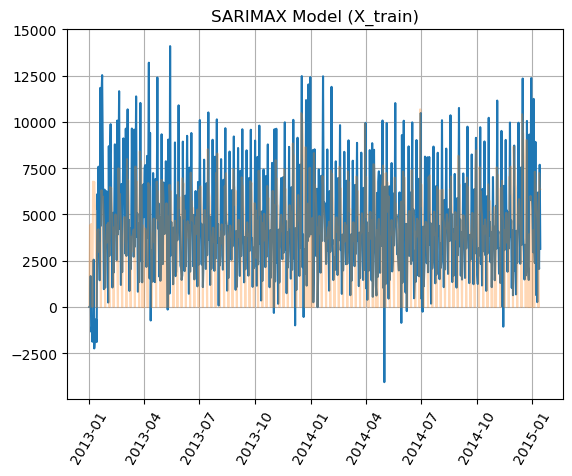

In [40]:
plt.plot(X_train.index, sarima.predict())
plt.plot(X_train.index, X_train, alpha = 0.3)
plt.xticks(rotation = 60)
plt.title('SARIMAX Model (X_train)')
plt.grid()

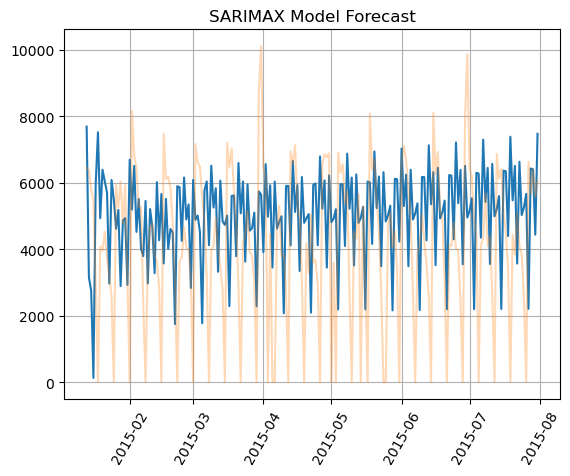

In [42]:
# It's looks like more noise.
# Predict X_test using this SARIMA Model
sarima_preds = sarima.predict(start=X_test.index[0],end=X_test.index[-1])
plt.plot(X_test.index, sarima_preds)
plt.plot(X_test.index, X_test, alpha = 0.3)
plt.xticks(rotation = 60)
plt.title('SARIMAX Model Forecast')
plt.grid()

In [43]:
sarima_mae_test = mean_absolute_error(X_test, sarima_preds)
sarima_rmse_test = mean_squared_error(X_test, sarima_preds, squared=False)

print(f'SARIMA MAE: {sarima_mae_test}')
print(f'SARIMA RMSE: {sarima_rmse_test}')

SARIMA MAE: 2249.6069449518236
SARIMA RMSE: 2874.3052827000447
